In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sns.set_theme(style='whitegrid')
pd.options.mode.chained_assignment = None  # Supress warning, default='warn'

# Read Data
In this section we read the data in after the preprocessing from the preprocessing notebook

In [2]:
df = pd.read_csv('../data/preprocessed/accepted_2007_to_2018Q4_preprocessed.csv')
print(f"Shape of df: {df.shape}")
df.head(5)

Shape of df: (1345310, 101)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10.0,MORTGAGE,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10.0,MORTGAGE,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10.0,MORTGAGE,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3.0,MORTGAGE,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
4,11950.0,11950.0,11950.0,36,13.44,405.18,C,C3,4.0,RENT,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


In [3]:
df.dtypes

loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                            int64
int_rate                      float64
                               ...   
total_bc_limit                float64
total_il_high_credit_limit    float64
hardship_flag                  object
disbursement_method            object
debt_settlement_flag           object
Length: 101, dtype: object

## Take Sample to Work with
TODO: Delete this later and run notebook on full data

In [4]:
# Take only fraction of the data
df = df.sample(frac = 0.10)
print(df.shape)

(134531, 101)


# Encode Categorical / Nominal Columns to numeric with OHE
Many Machine Learning algorithm need a numeric encoding of categorical data. In this section we remove features that are categorical and have too many expressions. For the remaining ones we encode them using a One Hot Encoder and the pandas dummy encoding method.

In [5]:
# Preview categorical data
df.dtypes[df.dtypes == "object"]

grade                   object
sub_grade               object
home_ownership          object
verification_status     object
pymnt_plan              object
purpose                 object
addr_state              object
initial_list_status     object
application_type        object
hardship_flag           object
disbursement_method     object
debt_settlement_flag    object
dtype: object

In [6]:
# Drop categorical columns that have too many realization for OHE
df = df.drop(["sub_grade", "purpose", "grade", "addr_state"], axis=1)
df.dtypes[df.dtypes == "object"]

home_ownership          object
verification_status     object
pymnt_plan              object
initial_list_status     object
application_type        object
hardship_flag           object
disbursement_method     object
debt_settlement_flag    object
dtype: object

## One Hot Encoder (OHE) of categorical data
A categorical feature / variable with $K$ realizations will be one hot encoded into $K-1$ binary columns.

In [7]:
# Get categorical columns names
categorical_columns = list(df.dtypes[df.dtypes == "object"].keys())
# Transform those categorical columns using One Hot Encoding
df = pd.get_dummies(data=df, columns=categorical_columns, drop_first=True)
# Preview
df.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,...,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,disbursement_method_DirectPay,debt_settlement_flag_Y
867434,35000.0,35000.0,35000.0,36,13.65,1190.28,2.0,320000.0,0,3.94,...,0,0,0,0,0,1,0,0,0,0
759833,6100.0,6100.0,6100.0,36,8.39,192.26,0.0,93500.0,0,13.50,...,0,0,0,1,1,0,1,0,0,0
401447,14400.0,14400.0,14400.0,36,13.59,489.30,NaN,71500.0,1,8.63,...,0,0,0,1,0,1,1,0,0,0
423338,18000.0,18000.0,18000.0,36,11.99,597.78,10.0,60000.0,0,23.30,...,0,0,0,0,0,0,1,0,0,0
529944,11000.0,11000.0,11000.0,36,12.62,368.63,3.0,100000.0,0,15.18,...,0,0,0,1,0,1,1,0,0,0
658620,30000.0,30000.0,29750.0,36,6.99,926.18,10.0,66600.0,0,12.25,...,0,0,0,1,1,0,1,0,0,0
532474,10150.0,10150.0,10150.0,36,14.08,347.30,NaN,55100.0,0,25.55,...,0,0,0,1,0,1,0,0,0,0
55053,7700.0,7700.0,7625.0,36,14.33,264.41,10.0,70000.0,1,10.56,...,0,0,0,0,1,0,0,0,0,0
340063,9600.0,9600.0,9600.0,36,9.49,307.48,10.0,72000.0,0,14.65,...,0,0,0,0,0,0,0,0,0,0
346717,14400.0,14400.0,14400.0,36,9.49,461.21,10.0,150000.0,0,18.83,...,0,0,0,0,0,0,1,0,0,0


In [8]:
# Show types of columns and counter
df.dtypes.value_counts()

float64    87
uint8      11
int64       2
dtype: int64

In [9]:
# Convert all values to float
df = df.astype(float)
# Preview
df.dtypes.value_counts()

float64    100
dtype: int64

# Preprocessing
We still have a few remaing NaNs value. We fill them using the corresponding median of each feature / column.

In [10]:
# Fill NaNs with Median
df = df.fillna(df.median())
# Preview
df.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,...,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,disbursement_method_DirectPay,debt_settlement_flag_Y
867434,35000.0,35000.0,35000.0,36.0,13.65,1190.28,2.0,320000.0,0.0,3.94,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
759833,6100.0,6100.0,6100.0,36.0,8.39,192.26,0.0,93500.0,0.0,13.50,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
401447,14400.0,14400.0,14400.0,36.0,13.59,489.30,6.0,71500.0,1.0,8.63,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
423338,18000.0,18000.0,18000.0,36.0,11.99,597.78,10.0,60000.0,0.0,23.30,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
529944,11000.0,11000.0,11000.0,36.0,12.62,368.63,3.0,100000.0,0.0,15.18,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


# Remove Highly Correlated Features
Keeping highly correlated features do not add much more information to our model but making it more complex. Thus we remove highly correlated features that exceed a certain threshold.

In [11]:
corr = df.corr()
corr["loan_status"].sort_values()

last_fico_range_high   -0.667289
last_fico_range_low    -0.576656
total_rec_prncp        -0.435683
last_pymnt_amnt        -0.346609
total_pymnt            -0.311751
                          ...   
recoveries              0.509232
loan_status             1.000000
out_prncp                    NaN
out_prncp_inv                NaN
policy_code                  NaN
Name: loan_status, Length: 100, dtype: float64

## Data Split
In this section we split the data into a training and test set. The corresponding model is then trained on the training set and tested on the test set.

In [12]:
# Fraction of test data
TEST_SIZE = 0.3

X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (94171, 99)
Shape of X_test: (40360, 99)
Shape of y_train: (94171,)
Shape of y_test: (40360,)


## Scale Data
To avoid bias, we scale each feature using the standard scaler, i.e. from each realization $x_{ij}$ the mean is subtracted divided by the standard deviation of each feature.

In [13]:
# Init object
scaler = StandardScaler()
# Scale X_train
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,0.183492,0.184738,0.187299,-0.564617,-1.440283,0.199948,1.120904,-0.418802,0.005532,-0.363192,...,-0.006517,-0.010305,2.866861,-0.808439,-0.794039,-0.672927,0.845174,-0.136277,-0.072987,-0.161162
1,0.000283,0.001443,0.004064,1.771112,1.733437,-0.166789,-0.836298,-0.178485,0.053726,-0.363192,...,-0.006517,-0.010305,-0.348814,-0.808439,-0.794039,1.486046,0.845174,-0.136277,-0.072987,-0.161162
2,-0.088458,-0.087341,-0.084690,1.771112,2.258888,-0.173128,0.282103,-0.771267,1.111623,-0.363192,...,-0.006517,-0.010305,-0.348814,1.236952,-0.794039,1.486046,0.845174,-0.136277,-0.072987,-0.161162
3,-0.732550,-0.731738,-0.728873,-0.564617,-0.235951,-0.653164,-1.115898,-0.819331,0.063997,-0.363192,...,-0.006517,-0.010305,-0.348814,1.236952,1.259385,-0.672927,-1.183188,-0.136277,-0.072987,-0.161162
4,-0.503540,-0.502619,-0.499830,-0.564617,-1.019923,-0.466091,-1.115898,-0.659119,-0.583066,4.234800,...,-0.006517,-0.010305,-0.348814,-0.808439,1.259385,-0.672927,-1.183188,-0.136277,-0.072987,-0.161162


# Fit Model

In [14]:
%%time
lr = LogisticRegression(fit_intercept=True, max_iter=1000, solver="saga")
lr.fit(X_train_scaled, y_train)

# Print coefficients and intercept
print(f"Intercept: {lr.intercept_}")
print(f"Coefficients: {lr.coef_}")

Intercept: [-2.26562142]
Coefficients: [[ 3.41926677e+00  4.27135677e+00  4.36219005e+00  6.44290066e-01
  -2.23607918e-01  3.61091565e+00 -2.02439422e-02 -1.81522997e-01
   3.17476810e-02 -5.96647863e-02  3.83721217e-03  3.81849093e-03
  -1.13389813e-02 -3.50757705e-02  2.91028353e-01  3.28977815e-02
  -8.67456133e-02 -1.45310470e-01  2.86831866e-02  0.00000000e+00
   0.00000000e+00 -5.61250517e+00 -5.41434043e+00 -7.86606913e+00
   2.80570143e+00  1.29254100e-01  4.38704559e+00  3.81112192e+00
  -4.31431996e+00 -1.40389398e+00 -9.25506050e-02  8.69386357e-04
  -3.14638935e-02  0.00000000e+00 -6.84785765e-04  3.52826833e-03
   4.31615141e-02 -4.85057898e-02 -4.49780432e-02 -6.94893050e-02
   9.58279915e-02  3.39491977e-02  3.15408890e-02 -2.24305544e-02
   8.55390020e-02 -2.48444339e-02 -1.45370704e-01  6.48249591e-02
   1.35175596e-01 -9.27753542e-02  5.83031745e-02 -3.26942514e-03
  -3.81204728e-02 -2.49498400e-02  7.19850321e-03  1.55557843e-02
   1.92939773e-02 -2.40006993e-02  3.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Test Model

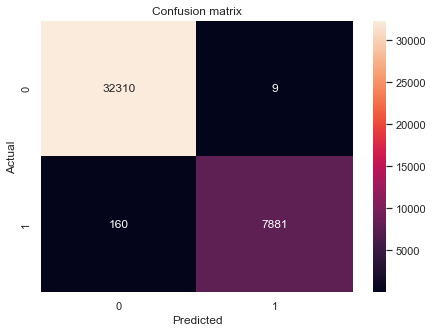

________________________________________________________________________________
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     32319
         1.0       1.00      0.98      0.99      8041

    accuracy                           1.00     40360
   macro avg       1.00      0.99      0.99     40360
weighted avg       1.00      1.00      1.00     40360

Information:
Precision: Percentage of correct positive predictions relative to total positive predictions
Recall: Percentage of correct positive predictions relative to total actual positives.
F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.
________________________________________________________________________________


In [15]:
# Scale Test Samples
X_test_scaled = scaler.transform(X_test)

# Predict in-sample values
y_pred = lr.predict(X_test_scaled)

# Plot Confusion matrics
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Heatmap plot settings
plt.figure(figsize=(7,5))
plt.title("Confusion matrix")
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot classification report
print(80 * "_")
print(classification_report(y_true=y_test, y_pred=y_pred))
print("Information:")
print("Precision: Percentage of correct positive predictions relative to total positive predictions")
print("Recall: Percentage of correct positive predictions relative to total actual positives.")
print("F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.")
print(80 * "_")

In [16]:
# Get Probability Predictions
pred_proba = pd.DataFrame(lr.predict_proba(X_test_scaled), columns=["P(y=0|x)", "P(y=1|x)"])
# Round to 5 decimal places
pred_proba = pred_proba.round(5)

pred_proba["y_pred"] = y_pred
pred_proba["y_actual"] = y_test.values

pred_proba.head(10)

,P(y=0|x),P(y=1|x),y_pred,y_actual
0,0.99836,0.00164,0.0,0.0
1,1.00000,0.00000,0.0,0.0
2,0.99973,0.00027,0.0,0.0
3,0.98888,0.01112,0.0,0.0
4,0.99780,0.00220,0.0,0.0
5,1.00000,0.00000,0.0,0.0
6,0.98505,0.01495,0.0,0.0
7,0.99409,0.00591,0.0,0.0
8,0.99720,0.00280,0.0,0.0
9,0.99990,0.00010,0.0,0.0
